## Scoring customer propensity to purchase
Training a model based on historical shopping actions on a website to identify the best prospects.

### Introduction
We have many visitors to our website every day, some purchase but many do not. We spend money re-targeting past visitors, we'd like to optimise this activity by targeting the visitors who are more likely to convert. To do this, we've taken data showing which parts of our website users interacted with, our questions are:

1. Which of these interactions effect a users likelyhood to purchase?
2. Can we score visitors from yesterday who did not purchase, to see who the most valuable prospects are?


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
from sklearn.model_selection  import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

First let's load in the training data file and take a look at it...

In [2]:
train = pd.read_csv('../input/training_sample.csv')

train.dtypes

UserID                     object
basket_icon_click           int64
basket_add_list             int64
basket_add_detail           int64
sort_by                     int64
image_picker                int64
account_page_click          int64
promo_banner_click          int64
detail_wishlist_add         int64
list_size_dropdown          int64
closed_minibasket_click     int64
checked_delivery_detail     int64
checked_returns_detail      int64
sign_in                     int64
saw_checkout                int64
saw_sizecharts              int64
saw_delivery                int64
saw_account_upgrade         int64
saw_homepage                int64
device_mobile               int64
device_computer             int64
device_tablet               int64
returning_user              int64
loc_uk                      int64
ordered                     int64
dtype: object

Okay, so we have a bunch of integer columns, each one reflecting an action on the website, and one object column, which looks like a user identifier, Let's take a look with some more methods...

In [3]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455401 entries, 0 to 455400
Data columns (total 25 columns):
UserID                     455401 non-null object
basket_icon_click          455401 non-null int64
basket_add_list            455401 non-null int64
basket_add_detail          455401 non-null int64
sort_by                    455401 non-null int64
image_picker               455401 non-null int64
account_page_click         455401 non-null int64
promo_banner_click         455401 non-null int64
detail_wishlist_add        455401 non-null int64
list_size_dropdown         455401 non-null int64
closed_minibasket_click    455401 non-null int64
checked_delivery_detail    455401 non-null int64
checked_returns_detail     455401 non-null int64
sign_in                    455401 non-null int64
saw_checkout               455401 non-null int64
saw_sizecharts             455401 non-null int64
saw_delivery               455401 non-null int64
saw_account_upgrade        455401 non-null int64
saw_ho

In [4]:
print(train.describe())

       basket_icon_click      ...              ordered
count      455401.000000      ...        455401.000000
mean            0.099150      ...             0.041926
std             0.298864      ...             0.200420
min             0.000000      ...             0.000000
25%             0.000000      ...             0.000000
50%             0.000000      ...             0.000000
75%             0.000000      ...             0.000000
max             1.000000      ...             1.000000

[8 rows x 24 columns]


So it looks like this data is just below half a million rows, with a total of 25 columns. Let's take a look at some of the data using HEAD...

In [5]:
train.head()

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0,1,1


Here we can see a clear snapshot of the data, we have 1's or 0's in the columns, indicating whether or not a user interacted with these areas of the website. The last column shows whether the user ordered or not, this will be important!


### Is there any correlation
In order to answer our first question, we can start by exploring any correlation between there individual website actions and an order, since we have all thes fields in our data.

We've got quite a few fields, so let's start with a heatmap to view correlations...

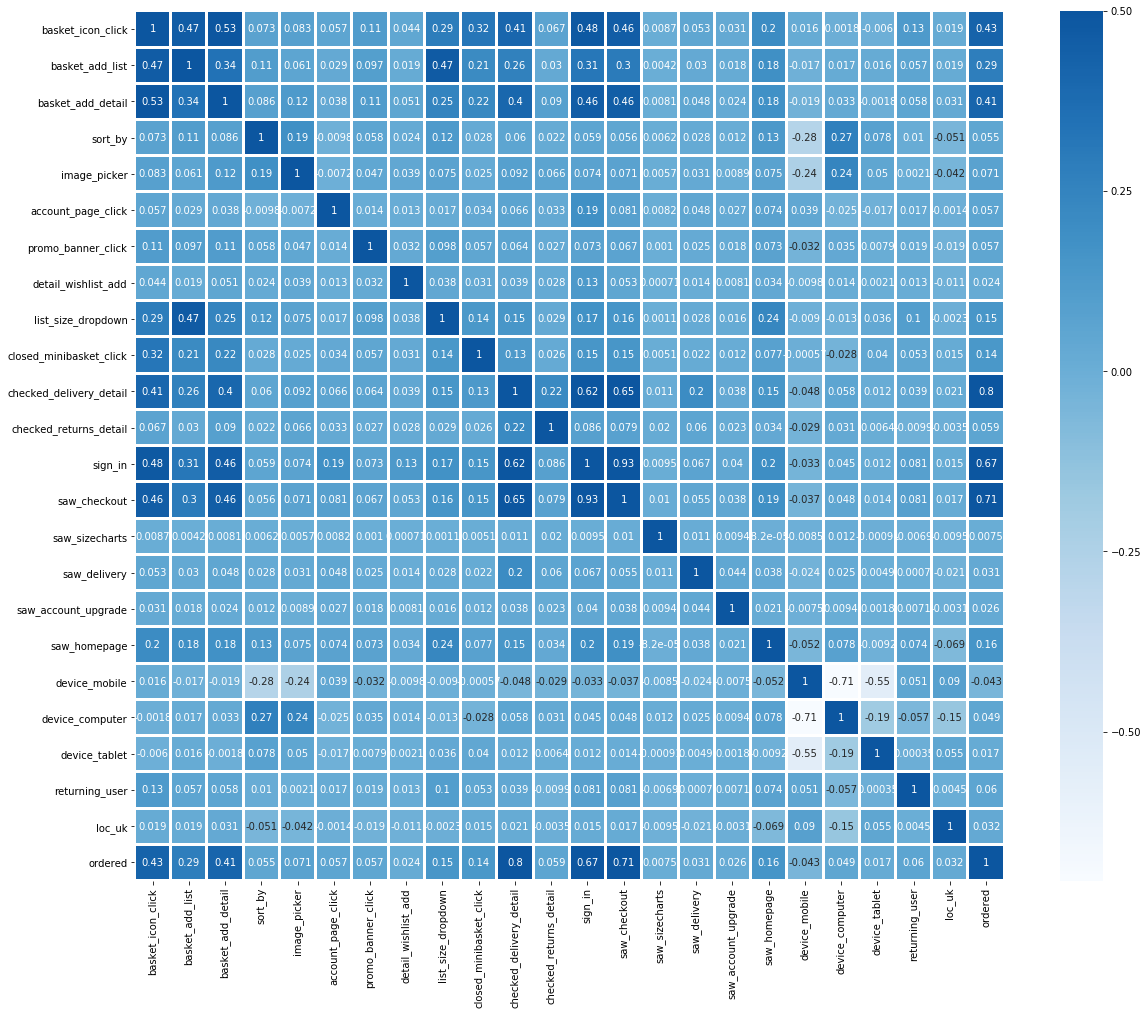

In [6]:
import seaborn as sns

plt.figure(figsize=(20, 16))
sns.heatmap(train.drop(['UserID'], axis=1).corr(), vmax=0.5, center=0,
            square=True, linewidths=2, cmap='Blues', annot=True)
plt.savefig("heatmap.png")
plt.show()

Interesting - there seems to be a multi collinearity with variables sign_in, saw_checkout and device_mobile. These variables are highly correlating with other independent variables. We can drop these variables. With Multi Collinearity, we cannot accurately the true effect of the variable.

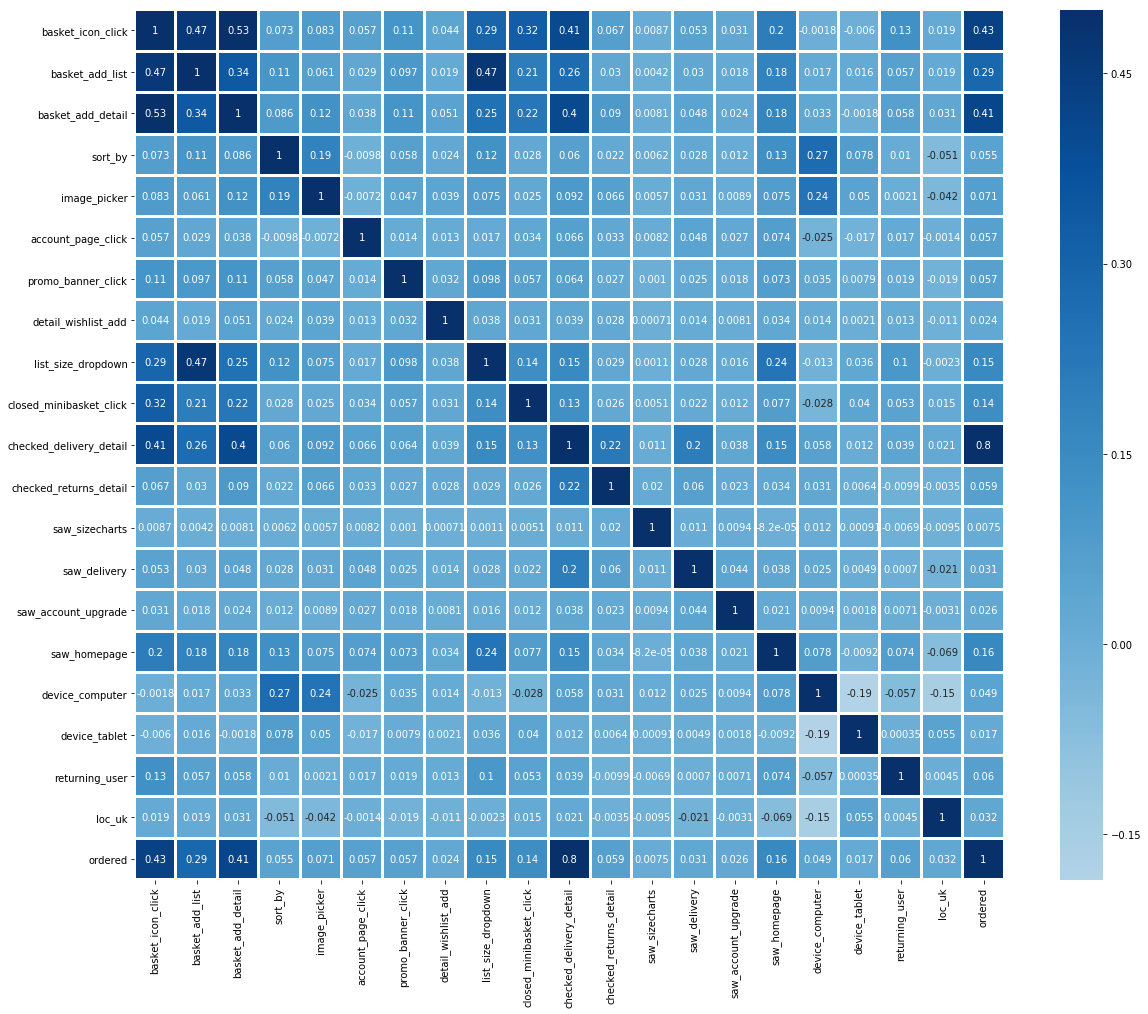

In [7]:
import seaborn as sns

plt.figure(figsize=(20, 16))
sns.heatmap(train.drop(['UserID','device_mobile', 'sign_in','saw_checkout'], axis=1).corr(), vmax=0.5, center=0,
            square=True, linewidths=2, cmap='Blues', annot=True)
plt.savefig("heatmap.png")
plt.show()

There is a strong correlation between visitors who ordered and visitors who checked_delivery_detail this makes sense! There are also strong correlations for people who basket icon clicks and orders - let's get a closer look at the correlations for orders...

In [8]:
train.corr()['ordered']

basket_icon_click          0.428334
basket_add_list            0.287666
basket_add_detail          0.414420
sort_by                    0.054636
image_picker               0.071492
account_page_click         0.057279
promo_banner_click         0.056533
detail_wishlist_add        0.023516
list_size_dropdown         0.154867
closed_minibasket_click    0.140011
checked_delivery_detail    0.798720
checked_returns_detail     0.059484
sign_in                    0.665556
saw_checkout               0.708986
saw_sizecharts             0.007548
saw_delivery               0.031461
saw_account_upgrade        0.025857
saw_homepage               0.157778
device_mobile             -0.042907
device_computer            0.049208
device_tablet              0.016939
returning_user             0.060295
loc_uk                     0.031643
ordered                    1.000000
Name: ordered, dtype: float64

Users who checked out the delivery options on a product detail page have an almost 80% correlation to orders. But, there isn't much correlation between users on a mobile and orders, so we should proabley remove this field from our predictor.

### Let's get predicting!
First we build our predictor and targets variables, we're going to drop 'ordered' form our predictors, as it is our target variable. We'll also remove 'UserID', as it has no impact on likelyhood to order and 'device_mobile' as we've seen it has a negative correlation to orders.

In [9]:
drop_ls = ['ordered','UserID','device_mobile','saw_checkout', 'saw_sizecharts', 'detail_wishlist_add']

# Drop columns with low correlation
predictors = train.drop(drop_ls, axis=1)
# predictors = train[['checked_delivery_pdp', 'basket_icon_click', 'sign_in', 'saw_checkout']]
targets = train.ordered

Let's take a look at our predictor columns to check we've included everything we wanted, and not left in something we shouldn't have...

In [10]:
print(predictors.columns)

Index(['basket_icon_click', 'basket_add_list', 'basket_add_detail', 'sort_by',
       'image_picker', 'account_page_click', 'promo_banner_click',
       'list_size_dropdown', 'closed_minibasket_click',
       'checked_delivery_detail', 'checked_returns_detail', 'sign_in',
       'saw_delivery', 'saw_account_upgrade', 'saw_homepage',
       'device_computer', 'device_tablet', 'returning_user', 'loc_uk'],
      dtype='object')


Now we split our data into train and test, with a test size of 30%.

In [11]:
X_train, X_test, y_train, y_test  =   train_test_split(predictors, targets, test_size=.3)

print( "Predictor - Training : ", X_train.shape, "Predictor - Testing : ", X_test.shape )

Predictor - Training :  (318780, 19) Predictor - Testing :  (136621, 19)


For our model we are going to use a naise bayes classififer, below we instantiate it, fit it, then predict using it, then we an analyse the accuracy of our predictions...

In [12]:
from sklearn.naive_bayes import GaussianNB

classifier=GaussianNB()
classifier=classifier.fit(X_train,y_train)

predictions=classifier.predict(X_test)

#Analyze accuracy of predictions
sklearn.metrics.confusion_matrix(y_test,predictions)

array([[128991,   1862],
       [    87,   5681]])

And apply an accuracy score to our model...

In [13]:
sklearn.metrics.accuracy_score(y_test, predictions)

0.98573425754459421

In [14]:
sklearn.metrics.f1_score( predictions, y_test)

0.85357974607467524

### Now to predict on the previous days visitors!
Start by loading in our sample data of the **previous days visitors who did not order**.

In [15]:
yesterday_prospects = pd.read_csv('../input/testing_sample.csv')

Now let's explore this DataFrame and check everything is as expected...

In [16]:
print(yesterday_prospects.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151655 entries, 0 to 151654
Data columns (total 25 columns):
UserID                     151655 non-null object
basket_icon_click          151655 non-null int64
basket_add_list            151655 non-null int64
basket_add_detail          151655 non-null int64
sort_by                    151655 non-null int64
image_picker               151655 non-null int64
account_page_click         151655 non-null int64
promo_banner_click         151655 non-null int64
detail_wishlist_add        151655 non-null int64
list_size_dropdown         151655 non-null int64
closed_minibasket_click    151655 non-null int64
checked_delivery_detail    151655 non-null int64
checked_returns_detail     151655 non-null int64
sign_in                    151655 non-null int64
saw_checkout               151655 non-null int64
saw_sizecharts             151655 non-null int64
saw_delivery               151655 non-null int64
saw_account_upgrade        151655 non-null int64
saw_ho

We're going to drop UserID before we predict on this data, so that is matches our training set, but before we do let's pop it into another variable, so we can pull back this identifier later. Once that's done we can drop our unwanted fields and print the head() to check our data...looking good?

In [17]:
userids = yesterday_prospects.UserID

yesterday_prospects = yesterday_prospects.drop(drop_ls, axis=1)

print(yesterday_prospects.head(10))

   basket_icon_click  basket_add_list   ...    returning_user  loc_uk
0                  0                0   ...                 0       1
1                  0                0   ...                 0       1
2                  0                0   ...                 0       1
3                  0                0   ...                 0       1
4                  0                0   ...                 0       1
5                  1                0   ...                 1       0
6                  0                0   ...                 1       1
7                  0                0   ...                 1       1
8                  1                1   ...                 1       1
9                  0                0   ...                 0       0

[10 rows x 19 columns]


Let's check the shape too, to confirm it is what our model will expect to recieve (e.g. the same number of columns)

In [18]:
yesterday_prospects.shape

(151655, 19)

Now we'll run our predictions and insert them into a field called 'propensity', print the head, and check it's all come togeather...

In [19]:
yesterday_prospects['propensity'] = classifier.predict_proba(yesterday_prospects)[:,1]

print(yesterday_prospects.head())

   basket_icon_click  basket_add_list      ...       loc_uk    propensity
0                  0                0      ...            1  2.022032e-64
1                  0                0      ...            1  2.022032e-64
2                  0                0      ...            1  2.022032e-64
3                  0                0      ...            1  1.396626e-61
4                  0                0      ...            1  2.022032e-64

[5 rows x 20 columns]


Looks good! Now we want to bring out UserIDs back, so we can identify these users in the future (note, these are dummy IDs).

In [20]:
pd.DataFrame(userids)
results = pd.concat([userids, yesterday_prospects], axis=1)

All done - let's take a look at our results data frame:

In [21]:
print(results.head(30))

                                 UserID      ...         propensity
0   9d24-25k4-47889d24-25k4-494b-398124      ...       2.022032e-64
1   7732-1k58-47887732-1k58-4475-679678      ...       2.022032e-64
2   94k2-632j-471394k2-632j-4b4j-228160      ...       2.022032e-64
3   jdd8-419d-4714jdd8-419d-4198-674376      ...       1.396626e-61
4   7473-7595-47147473-7595-4757-227547      ...       2.022032e-64
5   7j3d-j382-47157j3d-j382-4d3b-955343      ...       1.000000e+00
6   bb4d-8019-4715bb4d-8019-4d42-763898      ...       8.531135e-64
7   d09k-j446-4716d09k-j446-4469-572703      ...       4.015307e-64
8    1397-7143-47171397-7143-4969-95351      ...       3.940750e-39
9   3j36-dj4d-47183j36-dj4d-4478-404497      ...       1.349511e-68
10   82b1-659j-471882b1-659j-45j1-32901      ...       2.022032e-64
11  dj8d-141k-4718dj8d-141k-42db-743965      ...       4.015307e-64
12  dk79-707j-4718dk79-707j-4d6k-487319      ...       4.015307e-64
13  42d6-051d-471j42d6-051d-4634-595933      ...

In [22]:
results.to_csv('results.csv')

In [23]:
yp = pd.read_csv('../input/testing_sample.csv')

In [24]:
yp['ordered'].value_counts()

0    151655
Name: ordered, dtype: int64

In [25]:
pred = classifier.predict(yesterday_prospects[yesterday_prospects.columns[:-1]])

In [26]:
'%.2f is my accuracy score'%round(sklearn.metrics.accuracy_score(yp['ordered'], pred), 2)

'0.98 is my accuracy score'

In [27]:
sklearn.metrics.accuracy_score(yp['ordered'], pred)

0.98462299297748179